# Result Analysis

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# See all columns
pd.set_option("display.max_columns", None)

def plot_correlation_heatmap(df_hm, df_llm, suffixes=("_hm", "_llm")):
    """Plot a heatmap of correlations."""
    
    df_hm_llm_corr = df_hm.merge(df_llm, on="filenameid", suffixes=suffixes)
    df_hm_llm_corr = df_hm_llm_corr.select_dtypes(np.number).corr()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x_suffix, y_suffix = suffixes[0], suffixes[1]
    x_cols = [col for col in df_hm_llm_corr.columns if col.endswith(x_suffix)]
    y_cols = [col for col in df_hm_llm_corr.columns if col.endswith(y_suffix)]

    corr_matrix = df_hm_llm_corr.loc[x_cols, y_cols]
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Correlation Heatmap: Human vs LLM")
    fig.tight_layout()
    # plt.savefig(os.path.join(output_path, "correlation_heatmap.png"))   
    return fig , corr_matrix

# fig, corr_matrix = plot_correlation_heatmap(df_human_, df_jud)

# plt.savefig("output/evaluation/prometheus-2-7B/correlation_heatmap.png")

def get_corr_scores(df_human, df_jud):
    """Compute the correlation scores."""
    
    corr_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        with np.errstate(divide="ignore", invalid="ignore"): 
            corr_scores[col] = np.corrcoef(df_human[col], df_jud[col])[0, 1]
        
    return corr_scores

# corr_scores = get_corr_scores(df_human_, df_jud)
# corr_scores

def get_mae_scores(df_human, df_jud):
    """Compute the mean absolute error scores."""
    
    mae_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        mae_scores[col] = np.mean(np.abs(df_human[col] - df_jud[col]))
    return mae_scores

def get_mean_error(df_human, df_jud):
    """Compute the mean error scores."""
    
    mean_error = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        mean_error[col] = np.mean(df_human[col] - df_jud[col])
    return mean_error

# mae_scores = get_mae_scores(df_human_, df_jud)
# mae_scores

from sklearn.metrics import f1_score
def get_f1_scores(df_human, df_jud):
    """Compute the F1 scores."""
    
    f1_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        f1_scores[col] = f1_score(df_human[col], df_jud[col], average="weighted", zero_division=0)
    return f1_scores

def get_hits(df_human, df_jud):
    """Compute the hits."""
    
    hits = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        hits[col] = np.sum(df_human[col] == df_jud[col])
    return hits

def get_accuracy_scores(df_human, df_jud):
    """Compute the accuracy scores."""
    
    accuracy_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        accuracy_scores[col] = np.mean(df_human[col] == df_jud[col])
    return accuracy_scores

# f1_scores = get_f1_scores(df_human_, df_jud)
# f1_scores

def get_std(df):
    """Compute the st of the scores."""
    
    std_val = df.select_dtypes(int).std().to_dict()
    return std_val
 
def get_full_evaluation(df_human, df_jud, sort_variable="filenameid"):
    """Compute the full evaluation metrics."""
    
    if sort_variable is not None:
        df_human = df_human.sort_values(sort_variable)
        df_jud = df_jud.sort_values(sort_variable)
        
    corr_scores = get_corr_scores(df_human, df_jud)
    mae_scores = get_mae_scores(df_human, df_jud)
    f1_scores = get_f1_scores(df_human, df_jud)
    
    full_evaluation = pd.DataFrame({
        "Correlation": corr_scores,
        "MAE": mae_scores,
        "Mean_Error": get_mean_error(df_human, df_jud),
        # "F1": f1_scores,
        "accuracy": get_accuracy_scores(df_human, df_jud),
        "n_corrects": get_hits(df_human, df_jud),
        # "Human_Std": get_std(df_human),
        "LLM_Std": get_std(df_jud)
    })
    
    return full_evaluation


def plot_confusion_matrix(df_human, df_jud, col, title="Confusion Matrix", figsize=(5, 5), ax=None, show=True):
    """Plot the confusion matrix."""
    
    y_true = df_human[col].values
    # print("y_true", y_true)
    y_pred = df_jud[col].values
    # print("y_pred", y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
                        xticklabels=["1", "2", "3", "4", "5"],
                        yticklabels=["1", "2", "3", "4", "5"],
                        ax=ax, linewidths=0.5, linecolor="black")
    
    ax.set_xlabel("LLM")
    ax.set_ylabel("Expert")
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    return ax


def plot_confusion_matrices(df_human, df_jud, cols, title, figsize=(10, 10), rows=2):
    """Plot the confusion matrices for all columns."""
    n_plots = len(cols)
    fig, axs = plt.subplots(rows, n_plots // rows + 1, figsize=figsize)
    for i, col in enumerate(cols):
        ax = axs[i // rows, i % rows]
        plot_confusion_matrix(df_human, df_jud, col, ax=ax)
        ax.set_title(col)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    



# Llama 3B Instruct

In [4]:
df_llama_pred = pd.read_csv("output/evaluation/llama_3B_inst_eval/2025-04-03_13-05-13/llm_predictions.csv",
                            dtype={"filenameid": str})
df_llama_human = pd.read_csv("output/evaluation/llama_3B_inst_eval/2025-04-03_13-05-13/human_predictions.csv",
                             dtype={"filenameid": str})

# df_ex_pred = pd.read_csv("output/evaluation/llama_3B_inst_eval/2025-02-02_21-14-48/examples_predictions.csv",
#                          dtype={"filenameid": str})
# df_ex_human = pd.read_csv("output/evaluation/llama_3B_inst_eval/2025-02-02_21-14-48/examples_human_eval.csv",
#                          dtype={"filenameid": str})
# ls_examples = df_ex_pred["filenameid"].unique()

In [5]:
df_llama_human.columns

Index(['Content Relevance', 'Information Completeness',
       'Clarity and Structure', 'Content Accuracy', 'Hallucinations',
       'Impact of Hallucinations', 'Relevance to Practice', 'Overall Quality',
       'Positive highlights', 'Negative highlights', 'Other Comments',
       'filenameid'],
      dtype='object')

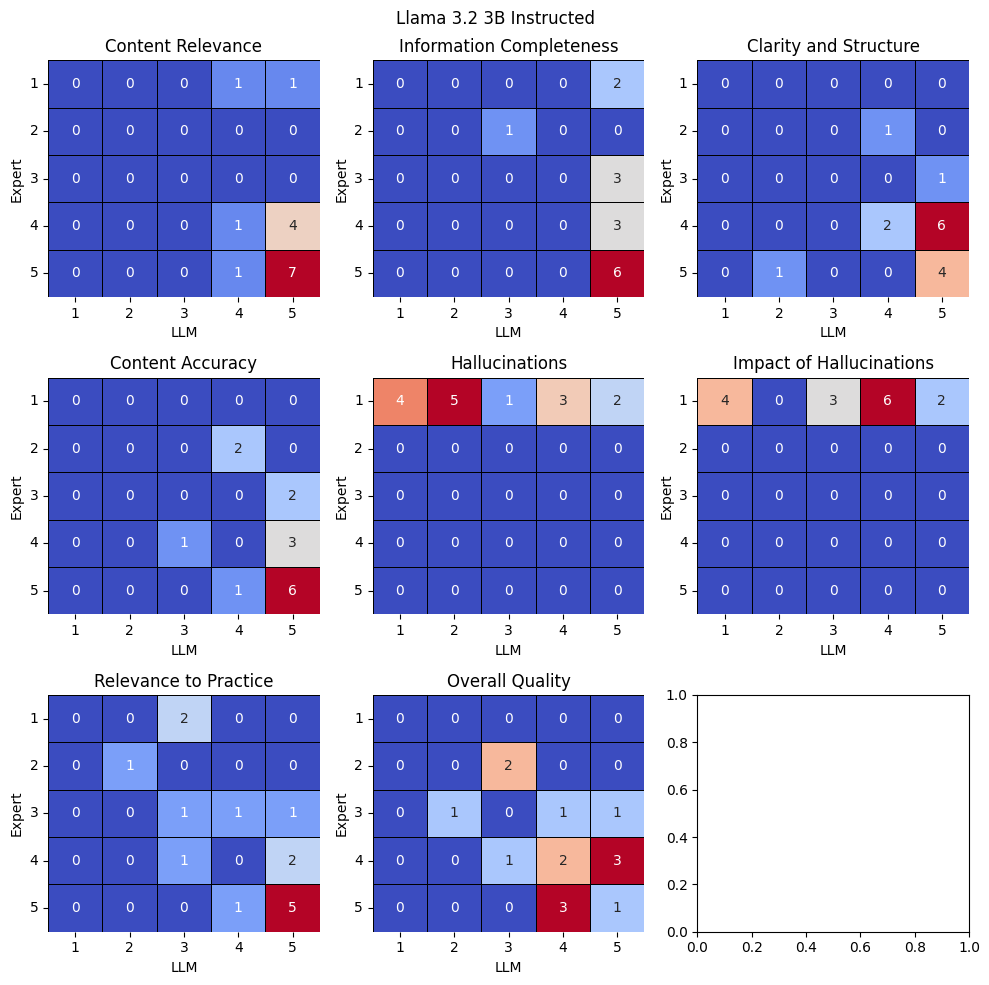

In [64]:
cols = ['Content Relevance', 'Information Completeness',
       'Clarity and Structure', 'Content Accuracy', 'Hallucinations',
       'Impact of Hallucinations', 'Relevance to Practice', 'Overall Quality',]

plot_confusion_matrices(df_llama_human, df_llama_pred, cols, rows=3,
                        title="Llama 3.2 3B Instructed",
                        figsize=(10, 10))


In [20]:
df_eval_llama = get_full_evaluation(df_llama_human, df_llama_pred)
df_eval_llama

,Correlation,MAE,Mean_Error,accuracy,n_corrects,LLM_Std
Content Relevance,0.305392,0.800000,-0.666667,0.533333,8,0.414039
Information Completeness,0.318529,1.200000,-1.200000,0.400000,6,0.516398
Clarity and Structure,-0.020690,0.866667,-0.466667,0.400000,6,0.828079
Content Accuracy,0.350758,0.866667,-0.600000,0.400000,6,0.617213
Hallucinations,NaN,1.600000,-1.600000,0.266667,4,1.454058
Impact of Hallucinations,NaN,2.133333,-2.133333,0.266667,4,1.457330
Relevance to Practice,0.729265,0.733333,-0.466667,0.466667,7,1.060099
Overall Quality,0.456435,0.866667,-0.200000,0.200000,3,0.925820


In [21]:
cols = ["Content Relevance",
        "Information Completeness",
        "Clarity and Structure",
        "Content Accuracy",
        "Hallucinations",
        "Impact of Hallucinations",
        "Relevance to Practice",
        "Overall Quality"]

In [22]:
df_llama_human_bin = (df_llama_human[cols] > 3).astype(int)
df_llama_human_bin["filenameid"] = df_llama_human["filenameid"]
df_llama_pred_bin = (df_llama_pred[cols] > 3).astype(int)
df_llama_pred_bin["filenameid"] = df_llama_pred["filenameid"]

df_eval_llama_bin = get_full_evaluation(df_llama_human_bin, df_llama_pred_bin)
df_eval_llama_bin

,Correlation,MAE,Mean_Error,accuracy,n_corrects,LLM_Std
Content Relevance,NaN,0.133333,-0.133333,0.866667,13,0.000000
Information Completeness,0.327327,0.333333,-0.333333,0.666667,10,0.258199
Clarity and Structure,-0.104828,0.200000,-0.066667,0.800000,12,0.258199
Content Accuracy,-0.161165,0.333333,-0.200000,0.666667,10,0.258199
Hallucinations,NaN,0.333333,-0.333333,0.666667,10,0.487950
Impact of Hallucinations,NaN,0.533333,-0.533333,0.466667,7,0.516398
Relevance to Practice,0.577350,0.200000,-0.066667,0.800000,12,0.487950
Overall Quality,0.533002,0.200000,-0.066667,0.800000,12,0.457738


In [76]:
df_llama_pred

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other comments on Generated/Original data sources,filenameid
0,5,5,5,5,1,1,5,5,The discharge summary effectively conveys the ...,NaN,The discharge summary is a direct representati...,29617510
1,5,5,5,5,1,1,5,5,NaN,NaN,NaN,31204375
2,5,5,5,5,2,3,5,5,The discharge summary effectively conveys the ...,The summary could benefit from more specific d...,The discharge summary is a faithful representa...,30072860_2
3,5,5,5,5,2,3,4,4,NaN,NaN,NaN,31056078
4,5,5,5,5,4,4,3,3,NaN,NaN,NaN,31486515
5,5,5,5,5,4,4,5,4,NaN,NaN,NaN,31512669
6,4,3,2,3,5,5,2,2,NaN,NaN,NaN,32997782
7,4,5,4,4,2,3,4,4,The discharge summary effectively conveys the ...,The summary could benefit from more specific d...,The discharge summary is a good representation...,31557359
8,5,5,5,5,4,4,5,4,The discharge summary effectively conveys the ...,The summary could be more concise and focused ...,The discharge summary is a direct representati...,26989133
9,5,5,5,5,1,1,5,5,NaN,NaN,NaN,31049155


## Prometheus

In [66]:

df_eval_prom = pd.read_csv("output/evaluation/prometheus-2-7B/complete_evaluation.csv")
df_prom_pred = pd.DataFrame(df_eval_prom["scores"].apply(eval).tolist())
df_prom_pred["filenameid"] = df_eval_prom["filenameid"]

df_prom_feedback = pd.DataFrame(df_eval_prom["feedbacks"].apply(eval).tolist())
df_prom_feedback["filenameid"] = df_eval_prom["filenameid"]

df_prom_human = pd.DataFrame(df_eval_prom["human_score"].apply(eval).tolist())
df_prom_human["filenameid"] = df_eval_prom["filenameid"]

df_prom_human.head()

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,,30072860_2
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,,31056078
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,,31486515


In [78]:
df_prom_feedback[df_prom_pred["Hallucinations"] > 1]["Hallucinations"].values

array(["The summary is entirely factual, containing no fabricated or inaccurate content. It accurately describes the patient's condition, history, clinical findings, risk assessment, procedural details, and post-procedure course. There is no evidence of hallucinations, fabrications, or distortions in the provided information. Each aspect of the patient's situation is carefully explained, offering a clear understanding of the situation. The summaries regarding the patient's past medical history, laboratory findings, and the technical aspects of the procedure are all reliable and reflective of standard medical practice. Moreover, the patient's subsequent follow-up and recovery progression are clearly communicated, thereby providing an accurate representation of the patient's journey through the medical treatment process. In light of the rigorous accuracy required by the score rubric, it can be concluded that the summary is of high quality and devoid of any fabricated or inaccurate conten

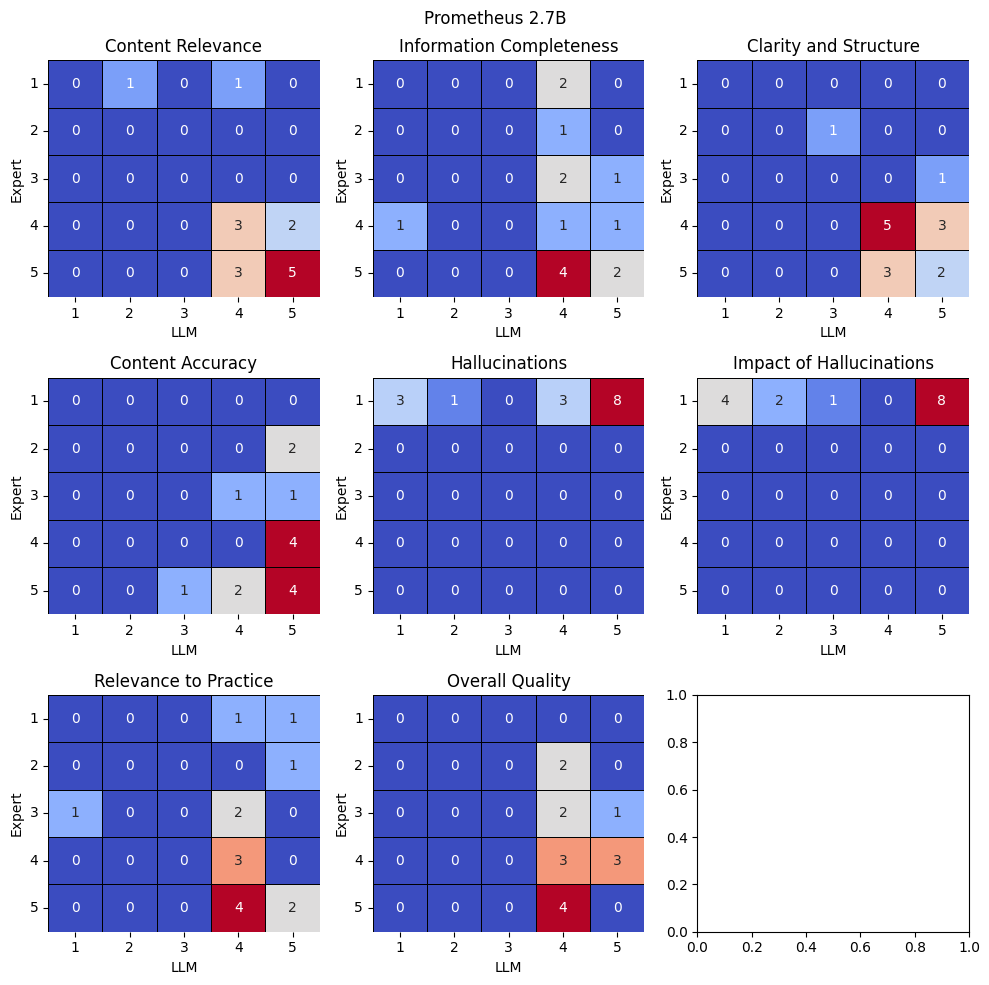

In [67]:
plot_confusion_matrices(df_prom_human, df_prom_pred, cols, rows=3,
                        title="Prometheus 2.7B",
                        figsize=(10, 10))

In [25]:
df_eval_prom = get_full_evaluation(df_prom_human, df_prom_pred)
df_eval_prom

,Correlation,MAE,Mean_Error,accuracy,n_corrects,LLM_Std
Content Relevance,0.666767,0.600000,-0.200000,0.533333,8,0.816497
Information Completeness,0.068455,1.333333,-0.400000,0.200000,3,0.961150
Clarity and Structure,0.323852,0.600000,-0.200000,0.466667,7,0.617213
Content Accuracy,-0.280607,1.133333,-0.600000,0.266667,4,0.617213
Hallucinations,NaN,2.800000,-2.800000,0.200000,3,1.656157
Impact of Hallucinations,NaN,2.400000,-2.400000,0.266667,4,1.843909
Relevance to Practice,0.017114,1.200000,-0.400000,0.333333,5,0.961150
Overall Quality,-0.030773,1.000000,-0.466667,0.200000,3,0.457738


In [26]:
df_prom_human_bin = (df_prom_human[cols] > 3).astype(int)
df_prom_human_bin["filenameid"] = df_prom_human["filenameid"]
df_prom_pred_bin = (df_prom_pred[cols] > 3).astype(int)
df_prom_pred_bin["filenameid"] = df_prom_pred["filenameid"]

df_eval_prom_bin = get_full_evaluation(df_prom_human_bin, df_prom_pred_bin)
df_eval_prom_bin

,Correlation,MAE,Mean_Error,accuracy,n_corrects,LLM_Std
Content Relevance,0.681385,0.066667,-0.066667,0.933333,14,0.258199
Information Completeness,-0.218218,0.466667,-0.333333,0.533333,8,0.258199
Clarity and Structure,0.681385,0.066667,-0.066667,0.933333,14,0.258199
Content Accuracy,-0.161165,0.333333,-0.200000,0.666667,10,0.258199
Hallucinations,NaN,0.733333,-0.733333,0.266667,4,0.457738
Impact of Hallucinations,NaN,0.533333,-0.533333,0.466667,7,0.516398
Relevance to Practice,0.327327,0.333333,-0.333333,0.666667,10,0.258199
Overall Quality,NaN,0.333333,-0.333333,0.666667,10,0.000000


# Llama Doctor

In [68]:
df_eval_doc = pd.read_csv("output/evaluation/llama_doctor_3B_inst/complete_evaluation.csv")
df_doc_pred = pd.DataFrame(df_eval_doc["scores"].apply(eval).tolist())
df_doc_pred["filenameid"] = df_eval_doc["filenameid"]

df_doc_feedback = pd.DataFrame(df_eval_doc["feedbacks"].apply(eval).tolist())
df_doc_feedback["filenameid"] = df_eval_doc["filenameid"]

# Fill NaN values with mode
df_doc_pred.fillna(df_doc_pred.mode().iloc[0], inplace=True)
# df_doc_pred = df_doc_pred.astype(int)

df_doc_human = pd.DataFrame(df_eval_doc["human_score"].apply(eval).tolist())
df_doc_human["filenameid"] = df_eval_doc["filenameid"]

df_doc_human.head()

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,,30072860_2
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,,31056078
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,,31486515


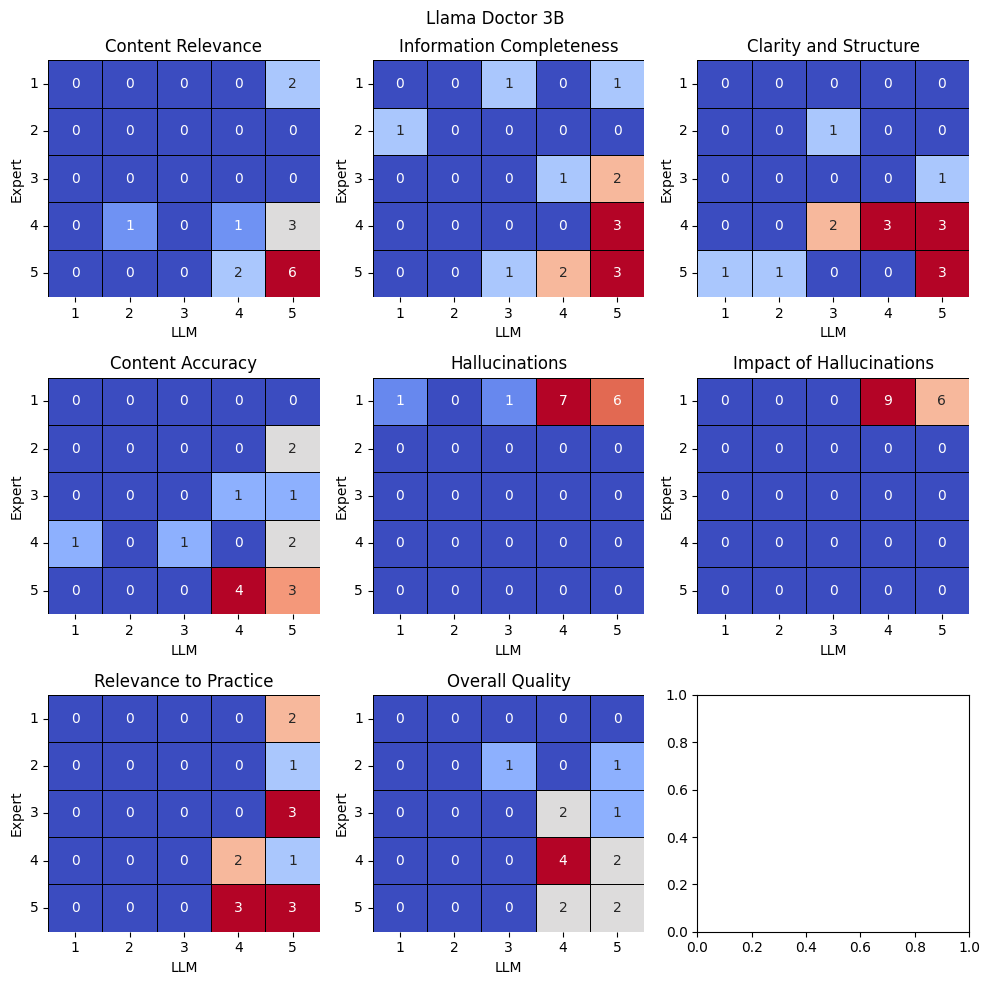

In [69]:
plot_confusion_matrices(df_doc_human, df_doc_pred, cols, rows=3,
                        title="Llama Doctor 3B",
                        figsize=(10, 10))

In [29]:
df_doc_pred

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,filenameid
0,4,5.0,3,5.0,3.0,4.0,4,4,29617510
1,5,4.0,5,3.0,4.0,4.0,4,4,31204375
2,5,5.0,5,4.0,5.0,4.0,5,4,30072860_2
3,5,5.0,5,5.0,5.0,5.0,5,4,31056078
4,5,4.0,5,5.0,5.0,4.0,5,5,31486515
5,4,3.0,4,5.0,4.0,4.0,4,4,31512669
6,5,1.0,1,1.0,1.0,4.0,5,5,32997782
7,4,5.0,4,4.0,4.0,4.0,4,4,31557359
8,5,5.0,2,4.0,5.0,5.0,5,5,26989133
9,5,4.0,5,4.0,4.0,4.0,4,4,31049155


In [30]:
df_eval_doc = get_full_evaluation(df_doc_human, df_doc_pred)
df_eval_doc.columns = [col + "_doctor" for col in df_eval_doc.columns]
df_eval_doc

,Correlation_doctor,MAE_doctor,Mean_Error_doctor,accuracy_doctor,n_corrects_doctor,LLM_Std_doctor
Content Relevance,-0.076348,1.000000,-0.466667,0.466667,7,0.828079
Information Completeness,0.311177,1.266667,-0.600000,0.200000,3,NaN
Clarity and Structure,-0.058008,1.000000,0.200000,0.400000,6,1.279881
Content Accuracy,-0.133858,1.266667,-0.200000,0.200000,3,NaN
Hallucinations,NaN,3.133333,-3.133333,0.066667,1,NaN
Impact of Hallucinations,NaN,3.400000,-3.400000,0.000000,0,NaN
Relevance to Practice,-0.471940,1.400000,-1.000000,0.333333,5,0.487950
Overall Quality,0.228218,0.800000,-0.533333,0.400000,6,0.617213


In [31]:
df_doc_human_bin = (df_doc_human[cols] > 3).astype(int)
df_doc_human_bin["filenameid"] = df_doc_human["filenameid"]
df_doc_pred_bin = (df_doc_pred[cols] > 3).astype(int)
df_doc_pred_bin["filenameid"] = df_doc_pred["filenameid"]

df_eval_doc_bin = get_full_evaluation(df_doc_human_bin, df_doc_pred_bin)
df_eval_doc_bin

,Correlation,MAE,Mean_Error,accuracy,n_corrects,LLM_Std
Content Relevance,-0.104828,0.200000,-0.066667,0.800000,12,0.258199
Information Completeness,0.272166,0.333333,-0.200000,0.666667,10,0.414039
Clarity and Structure,0.138675,0.333333,0.200000,0.666667,10,0.487950
Content Accuracy,-0.236525,0.400000,-0.133333,0.600000,9,0.351866
Hallucinations,NaN,0.866667,-0.866667,0.133333,2,0.351866
Impact of Hallucinations,NaN,1.000000,-1.000000,0.000000,0,0.000000
Relevance to Practice,NaN,0.400000,-0.400000,0.600000,9,0.000000
Overall Quality,0.377964,0.266667,-0.266667,0.733333,11,0.258199


# LLama with Prometheus Prompt

In [71]:
df_eval_llpr = pd.read_csv("output/evaluation/llama_3B_inst_std_prompt/complete_evaluation.csv")
df_llpr_pred = pd.DataFrame(df_eval_llpr["scores"].apply(eval).tolist())
df_llpr_pred["filenameid"] = df_eval_llpr["filenameid"]

# Fill NaN values with mode
df_llpr_pred.fillna(df_llpr_pred.mode().iloc[0], inplace=True)

df_llpr_feedback = pd.DataFrame(df_eval_llpr["feedbacks"].apply(eval).tolist())
df_llpr_feedback["filenameid"] = df_eval_llpr["filenameid"]

df_llpr_human = pd.DataFrame(df_eval_llpr["human_score"].apply(eval).tolist())
df_llpr_human["filenameid"] = df_eval_llpr["filenameid"]

df_llpr_human.head()

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,,30072860_2
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,,31056078
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,,31486515


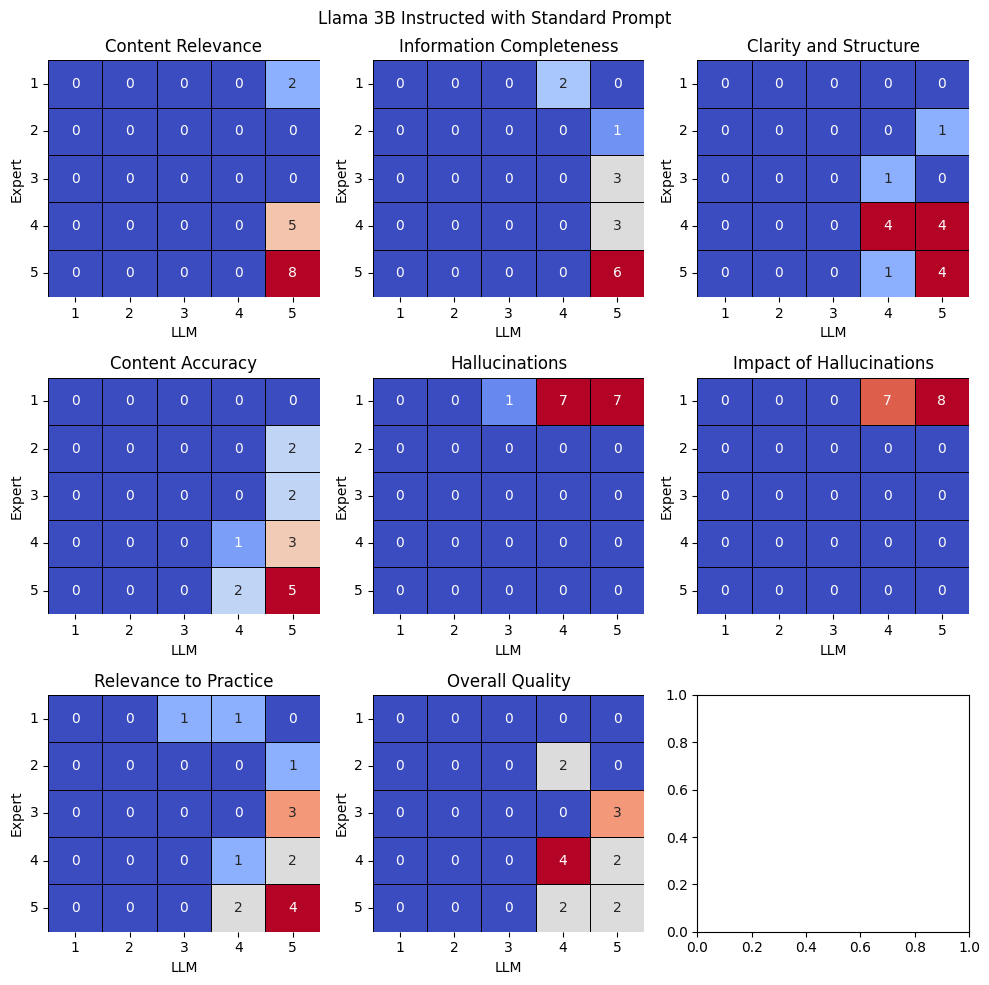

In [72]:
plot_confusion_matrices(df_llpr_human, df_llpr_pred, cols, rows=3,
                        title="Llama 3B Instructed with Standard Prompt",
                        figsize=(10, 10))

In [70]:
df_eval_llpr = get_full_evaluation(df_llpr_human, df_llpr_pred)
df_eval_llpr.columns = [col + "_llama_prom" for col in df_eval_llpr.columns]
df_eval_llpr

,Correlation_llama_prom,MAE_llama_prom,Mean_Error_llama_prom,accuracy_llama_prom,n_corrects_llama_prom,LLM_Std_llama_prom
Content Relevance,NaN,0.866667,-0.866667,0.533333,8,0.000000
Information Completeness,0.747958,1.200000,-1.200000,0.400000,6,0.351866
Clarity and Structure,0.135147,0.600000,-0.466667,0.533333,8,0.507093
Content Accuracy,-0.282355,1.000000,-0.733333,0.400000,6,0.414039
Hallucinations,NaN,3.400000,-3.400000,0.000000,0,0.632456
Impact of Hallucinations,NaN,3.533333,-3.533333,0.000000,0,0.516398
Relevance to Practice,0.390117,1.200000,-0.933333,0.333333,5,0.632456
Overall Quality,0.054554,0.933333,-0.666667,0.400000,6,0.516398


# Total comparison

In [73]:

df_eval_total = pd.merge(df_eval_llama, df_eval_prom, left_index=True, right_index=True, suffixes=("_llama", "_prometheus"))
df_eval_total = pd.merge(df_eval_total, df_eval_doc, left_index=True, right_index=True, suffixes=("", "_doctor"))
df_eval_total = pd.merge(df_eval_total, df_eval_llpr, left_index=True, right_index=True, suffixes=("", "_llama_prom"))

df_eval_total = df_eval_total[np.sort(df_eval_total.columns)].drop(index=["Hallucinations", "Impact of Hallucinations"])
df_eval_total

,Correlation_doctor,Correlation_llama,Correlation_llama_prom,Correlation_prometheus,LLM_Std_doctor,LLM_Std_llama,LLM_Std_llama_prom,LLM_Std_prometheus,MAE_doctor,MAE_llama,MAE_llama_prom,MAE_prometheus,Mean_Error_doctor,Mean_Error_llama,Mean_Error_llama_prom,Mean_Error_prometheus,accuracy_doctor,accuracy_llama,accuracy_llama_prom,accuracy_prometheus,n_corrects_doctor,n_corrects_llama,n_corrects_llama_prom,n_corrects_prometheus
Content Relevance,-0.076348,0.305392,NaN,0.666767,0.828079,0.414039,0.000000,0.816497,1.000000,0.800000,0.866667,0.600000,-0.466667,-0.666667,-0.866667,-0.200000,0.466667,0.533333,0.533333,0.533333,7,8,8,8
Information Completeness,0.311177,0.318529,0.747958,0.068455,NaN,0.516398,0.351866,0.961150,1.266667,1.200000,1.200000,1.333333,-0.600000,-1.200000,-1.200000,-0.400000,0.200000,0.400000,0.400000,0.200000,3,6,6,3
Clarity and Structure,-0.058008,-0.020690,0.135147,0.323852,1.279881,0.828079,0.507093,0.617213,1.000000,0.866667,0.600000,0.600000,0.200000,-0.466667,-0.466667,-0.200000,0.400000,0.400000,0.533333,0.466667,6,6,8,7
Content Accuracy,-0.133858,0.350758,-0.282355,-0.280607,NaN,0.617213,0.414039,0.617213,1.266667,0.866667,1.000000,1.133333,-0.200000,-0.600000,-0.733333,-0.600000,0.200000,0.400000,0.400000,0.266667,3,6,6,4
Relevance to Practice,-0.471940,0.729265,0.390117,0.017114,0.487950,1.060099,0.632456,0.961150,1.400000,0.733333,1.200000,1.200000,-1.000000,-0.466667,-0.933333,-0.400000,0.333333,0.466667,0.333333,0.333333,5,7,5,5
Overall Quality,0.228218,0.456435,0.054554,-0.030773,0.617213,0.925820,0.516398,0.457738,0.800000,0.866667,0.933333,1.000000,-0.533333,-0.200000,-0.666667,-0.466667,0.400000,0.200000,0.400000,0.200000,6,3,6,3


In [74]:
df_eval_total.mean()

Correlation_doctor       -0.033460
Correlation_llama         0.356615
Correlation_llama_prom    0.209084
Correlation_prometheus    0.127468
LLM_Std_doctor            0.803281
LLM_Std_llama             0.726941
LLM_Std_llama_prom        0.403642
LLM_Std_prometheus        0.738494
MAE_doctor                1.122222
MAE_llama                 0.888889
MAE_llama_prom            0.966667
MAE_prometheus            0.977778
Mean_Error_doctor        -0.433333
Mean_Error_llama         -0.600000
Mean_Error_llama_prom    -0.811111
Mean_Error_prometheus    -0.377778
accuracy_doctor           0.333333
accuracy_llama            0.400000
accuracy_llama_prom       0.433333
accuracy_prometheus       0.333333
n_corrects_doctor         5.000000
n_corrects_llama          6.000000
n_corrects_llama_prom     6.500000
n_corrects_prometheus     5.000000
dtype: float64

In [79]:
print(df_llpr_human.iloc[1].to_markdown())

|                          | 1                                                                                                                                                                                                                                                                             |
|:-------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content Relevance        | 4                                                                                                                                                                                                                                                                             |
| Information Completeness | 3                                                                   

In [57]:
print(df_llpr_feedback.iloc[1].to_markdown())

|                          | 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
|:-------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [80]:
print(df_prom_feedback.iloc[1].to_markdown())

|                          | 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|:-------------------------|:---------

In [81]:
print(df_doc_feedback.iloc[1].to_markdown())

|                          | 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          